In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import subprocess
import torch

In [6]:
train_data_path='/content/sample_data/mnist_train_small.csv'
if not os.path.exists(train_data_path):
  print("Loading module failed: Could not locate data at %s."%train_data_path)

In [4]:
!mkdir -p ./src
src_directory=os.getcwd()+'/src'
src_file=src_directory+'/mnist.py'
subprocess.call(['wget','https://raw.githubusercontent.com/Marcin-Kisielowski/MNIST/main/mnist.py','-O',str(src_file)])
sys.path.append(src_directory)
import mnist
%matplotlib inline

Training on device  cuda


In [7]:
learning_rate=1.0e-01

resnet=mnist.ResNetModelTrainer(learning_rate)
split_ratio=[80,20]
resnet.load_data(train_data_path,split_ratio)

training time: 117.067480 	 train accuracy: 0.997125 	 valid accuracy: 0.986000 


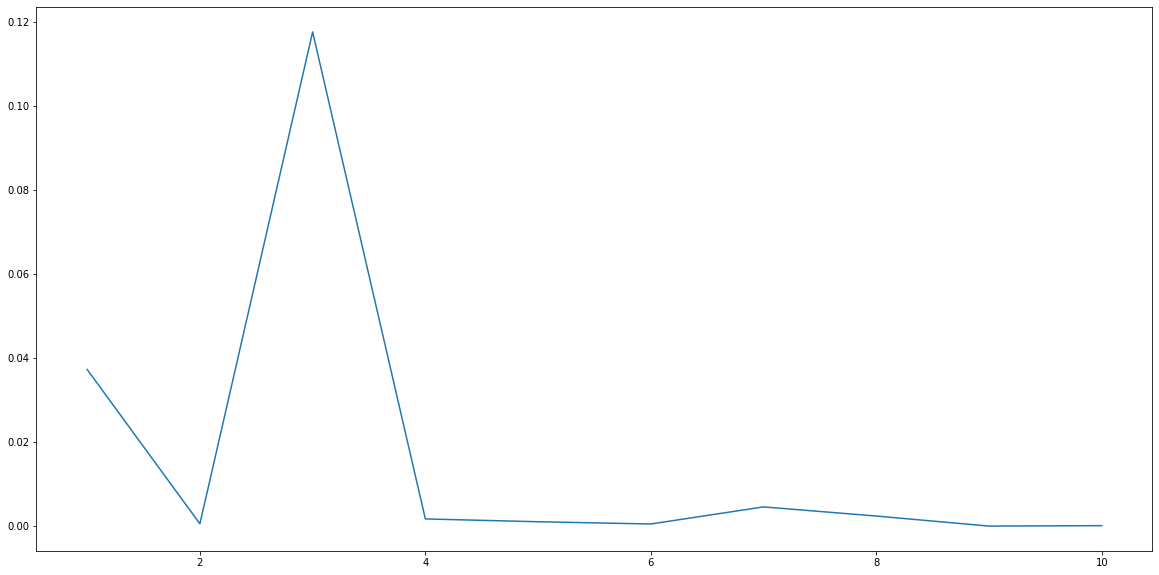

In [9]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 110.329035 	 train accuracy: 0.999813 	 valid accuracy: 0.990000 


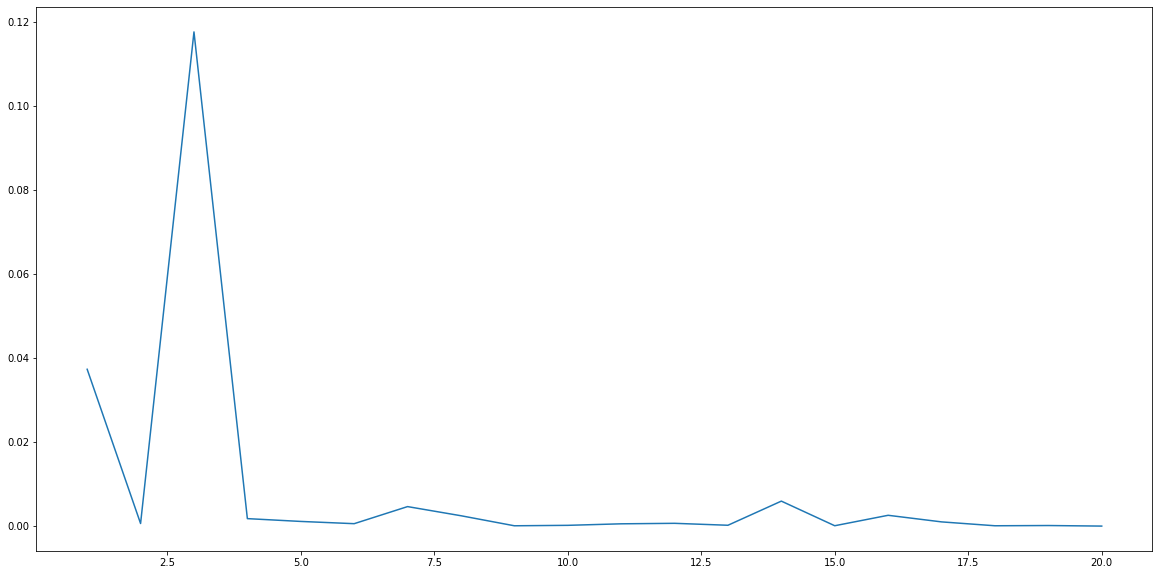

In [10]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 111.596833 	 train accuracy: 1.000000 	 valid accuracy: 0.991750 


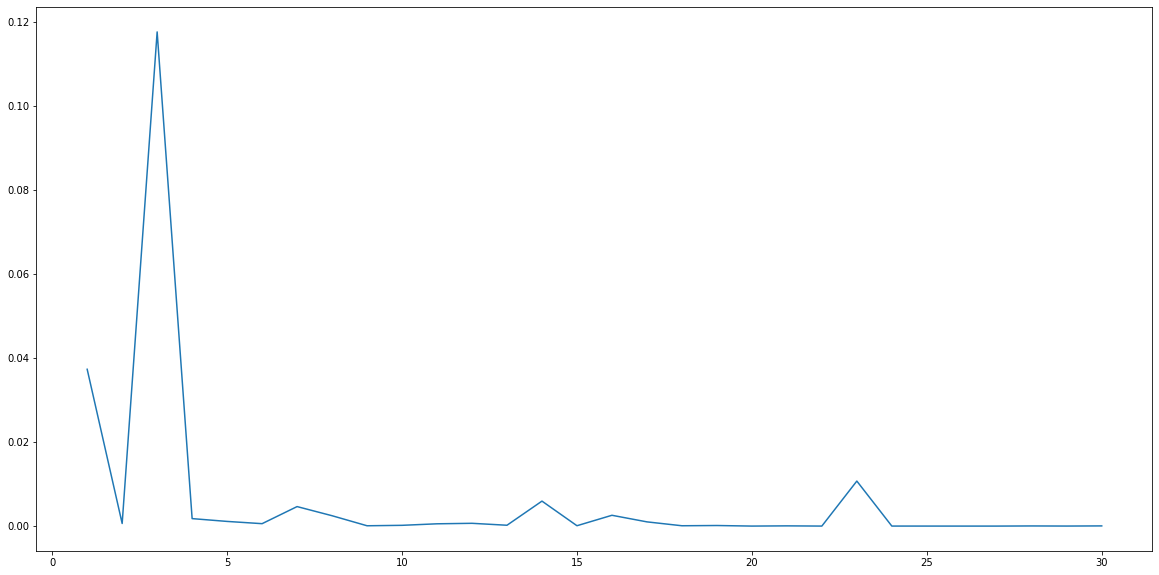

In [11]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 112.104718 	 train accuracy: 0.999188 	 valid accuracy: 0.990000 


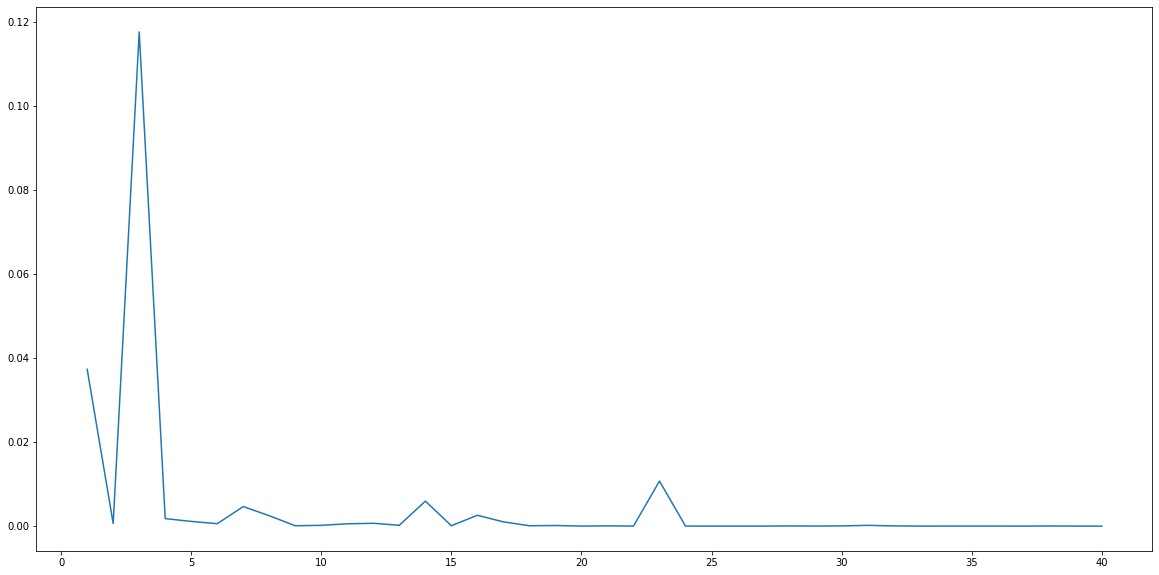

In [12]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 112.400199 	 train accuracy: 0.999938 	 valid accuracy: 0.991250 


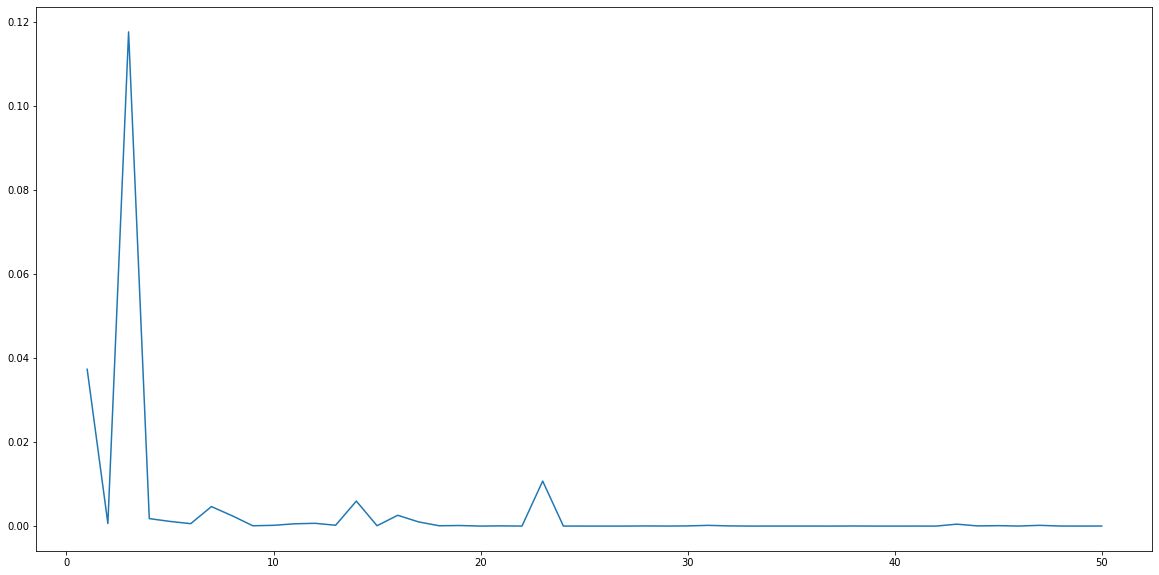

In [16]:
learning_rate=1.0e-03

resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 111.714478 	 train accuracy: 0.999938 	 valid accuracy: 0.991500 


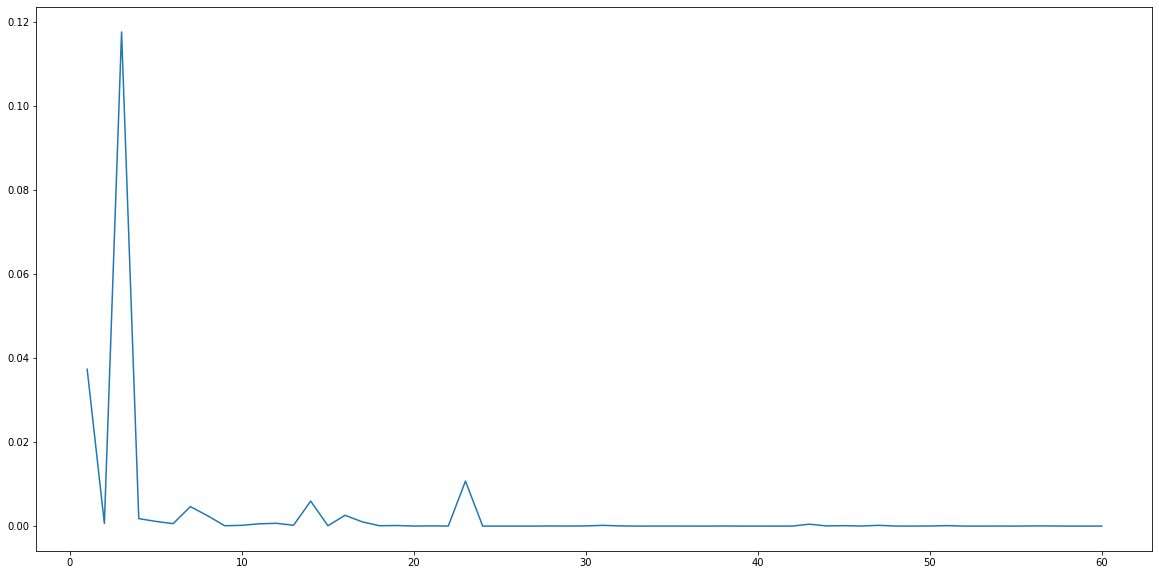

In [17]:
learning_rate=1.0e-03

resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 112.250015 	 train accuracy: 1.000000 	 valid accuracy: 0.991750 


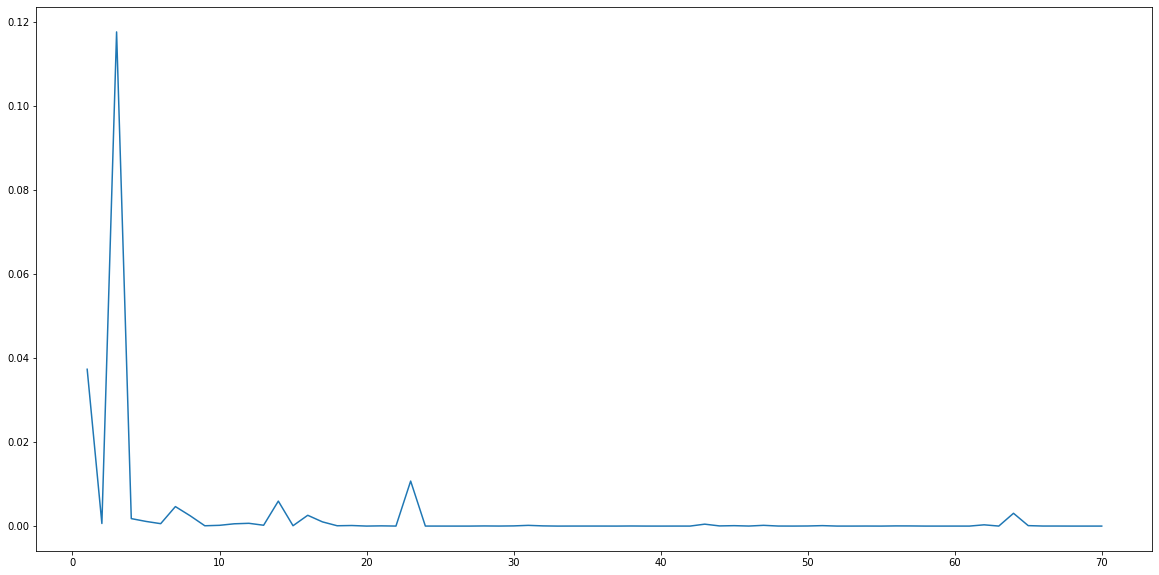

In [18]:
learning_rate=1.0e-03

resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

In [ ]:
class MNISTdigits2dTest(torch.utils.data.Dataset):
  def __init__(self, file_name):
        'Initialization'
        test_data=pd.read_csv(file_name)
        data_points=test_data.to_numpy()
        self.data_tensor=torch.from_numpy(data_points/255).float()
        self.data_tensor=self.data_tensor.view(-1,1,28,28)
  def __len__(self):
        'Denotes the total number of samples'
        return self.data_tensor.shape[0]

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
       
        X = self.data_tensor[index,:]
        if self.transform:
            X = self.transform(X)

        return index+1, X

In [ ]:
def create_submission_file(model,out_file_name):
    model.eval()
    data_set=MNISTdigits2dTest('../input/digit-recognizer/test.csv')
    data_loader=torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=False)
    indices=[]
    predictions=[]
    with torch.no_grad():
        for batch_indices,batch_imgs in data_loader:
            batch_imgs=batch_imgs.to(device=available_device)
            batch_indices=batch_indices.to(device=available_device)
            _, batch_predictions = torch.max(model(batch_imgs), dim=1)
            indices.append(batch_indices)
            predictions.append(batch_predictions)
    tensor_indices=torch.cat(tuple(indices),dim=0)
    tensor_predictions=torch.cat(tuple(predictions),dim=0)
    result_data_frame=pd.DataFrame({'ImageId':tensor_indices.cpu().numpy(), 'Label':tensor_predictions.cpu().numpy()})
    result_data_frame.set_index('ImageId')
    result_data_frame.to_csv(out_file_name,index=False)

In [ ]:
create_submission_file(resnet.model,'./submission.csv')